### Import

In [4]:
# !pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.style.use("ggplot")
plt.rc('font', family='NanumGothic')

### Data Load

In [2]:
customer = pd.read_csv('./customers.csv')
location = pd.read_csv('./locations.csv')
order_items = pd.read_csv('./order_items.csv')
orders = pd.read_csv('./orders.csv')
payments = pd.read_csv('./payments.csv')
product = pd.read_csv('./products.csv')
review = pd.read_csv('./reviews.csv')
seller = pd.read_csv('./sellers.csv')

### Data

In [3]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87955 entries, 0 to 87954
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Customer_id              87955 non-null  object
 1   Customer_unique_id       87955 non-null  object
 2   Customer_zipcode_prefix  87955 non-null  int64 
 3   Customer_city            87955 non-null  object
 4   Customer_state           87955 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87955 entries, 0 to 87954
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Order_id                       87955 non-null  object
 1   Customer_id                    87955 non-null  object
 2   Order_status                   87955 non-null  object
 3   Order_purchase_timestamp       87955 non-null  object
 4   Order_delivered_carrier_date   87955 non-null  object
 5   Order_delivered_customer_date  87955 non-null  object
 6   Order_estimated_delivery_date  87955 non-null  object
dtypes: object(7)
memory usage: 4.7+ MB


In [5]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100557 entries, 0 to 100556
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Order_id       100557 non-null  object 
 1   Order_item_id  100557 non-null  int64  
 2   Product_id     100557 non-null  object 
 3   Seller_id      100557 non-null  object 
 4   Price          100557 non-null  float64
 5   Freight_value  100557 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


### EDA

#### Top10 제품 카테고리 시각화

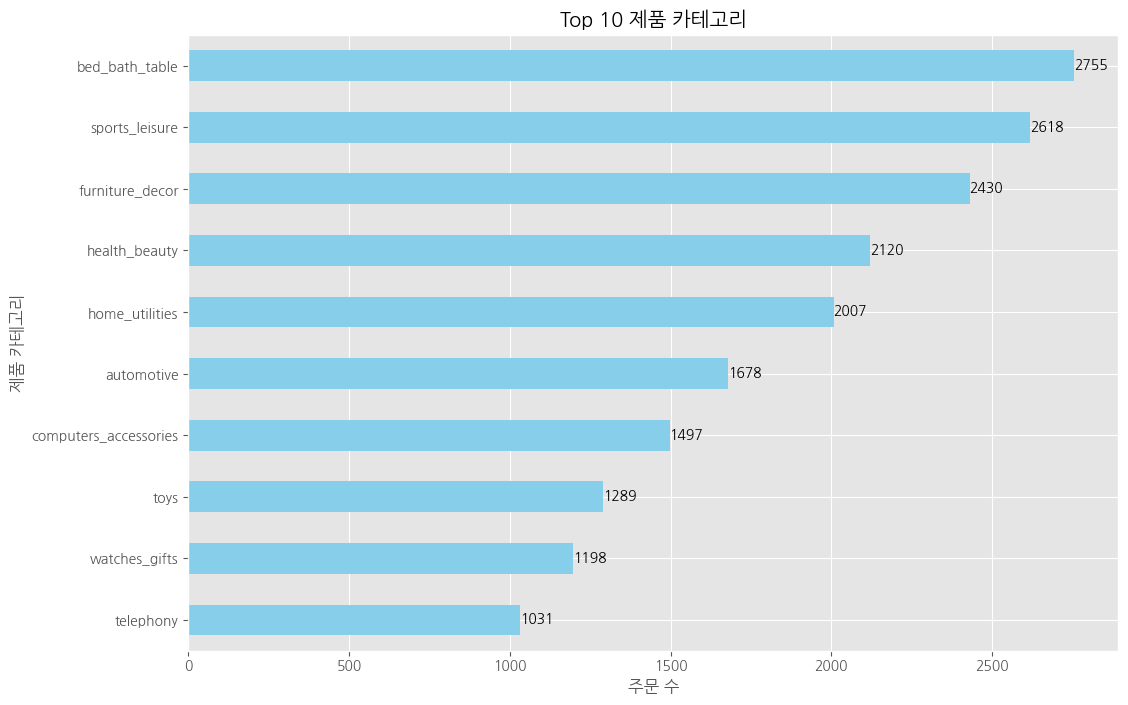

In [6]:
# 카테고리별 주문 수 계산
category_cnt = product['Product_category_name'].value_counts().head(10)

plt.figure(figsize=(12, 8))
bars = category_cnt.sort_values(ascending=True).plot(kind='barh', color='skyblue')

plt.title('Top 10 제품 카테고리')
plt.xlabel('주문 수')
plt.ylabel('제품 카테고리')

# 각 바 위에 값 표시
for bar in bars.containers[0]:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center')

plt.show()

#### 고객 Top 10 도시 시각화

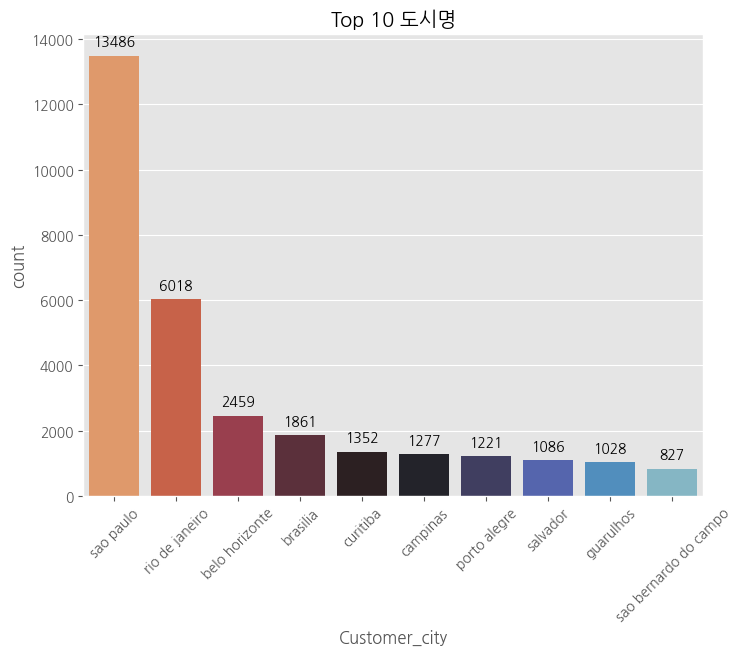

In [7]:
# 상위 10개 도시 선택
top10_cities = customer['Customer_city'].value_counts().head(10).index

# 상위 10개 도시에 대한 데이터만 필터링
data = customer[customer['Customer_city'].isin(top10_cities)]

# 시각화
plt.figure(figsize=(8,6))
ax = sns.countplot(x='Customer_city', data=data,
                   order=data['Customer_city'].value_counts().index, 
                   palette='icefire_r')

plt.title('Top 10 도시명')
plt.xticks(rotation=45) # 도시 이름이 긴 경우를 위해 x축 라벨 회전

# 각 바 위에 값 표시
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


#### 지불형태 시각화

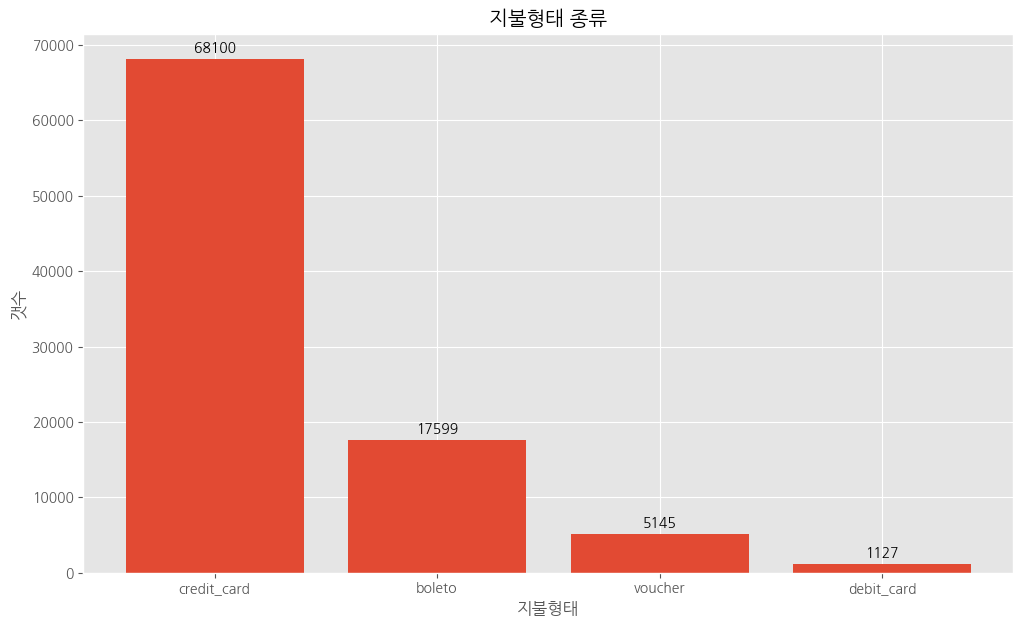

In [8]:
# 지불 형태별 개수 계산
category_counts = payments['Payment_type'].value_counts()

# 바 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(category_counts.index, category_counts)

# 각 바에 카운트 값 표시
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xlabel('지불형태')
ax.set_ylabel('갯수')
ax.set_title('지불형태 종류')

plt.show()

### KPI Definition

#### 월별 매출 시각화

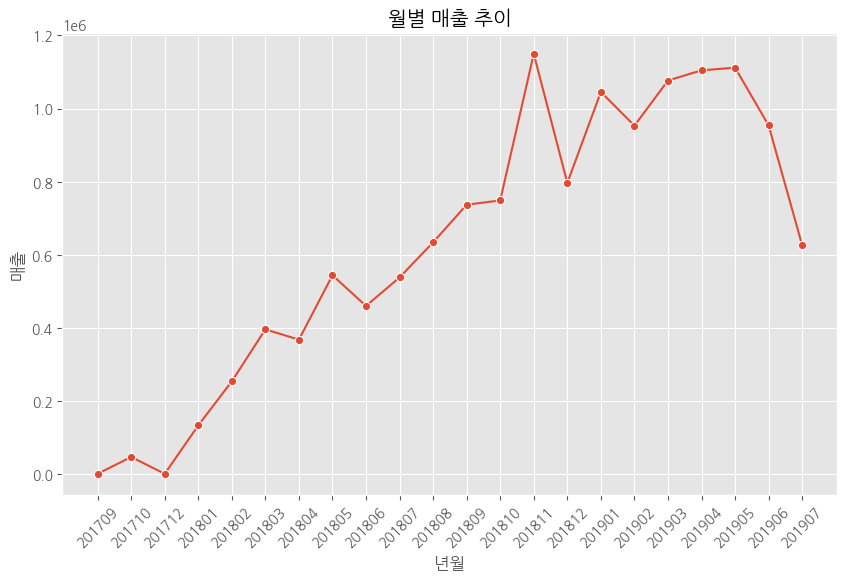

In [9]:
order = orders.copy()

order['Order_purchase_timestamp'] = pd.to_datetime(order['Order_purchase_timestamp'])
order['YearMonth'] = order['Order_purchase_timestamp'].dt.strftime('%Y%m')

merged_orders = pd.merge(order, order_items, on='Order_id', how='left')
merged_orders['Revenue'] = merged_orders['Price'] * merged_orders['Order_item_id']
monthly_revenue = merged_orders.groupby('YearMonth')['Revenue'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x='YearMonth', y='Revenue', data=monthly_revenue, marker='o')
plt.title('월별 매출 추이')
plt.xlabel('년월')
plt.ylabel('매출')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [10]:
orders_customers = pd.merge(order, customer, on='Customer_id', how='inner')
orders_monthly_active = orders_customers.groupby('YearMonth')['Customer_unique_id'].nunique().reset_index()

orders_monthly_active.head()

,YearMonth,Customer_unique_id
0,201709,1
1,201710,263
2,201712,1
3,201801,716
4,201802,1616


#### MAU

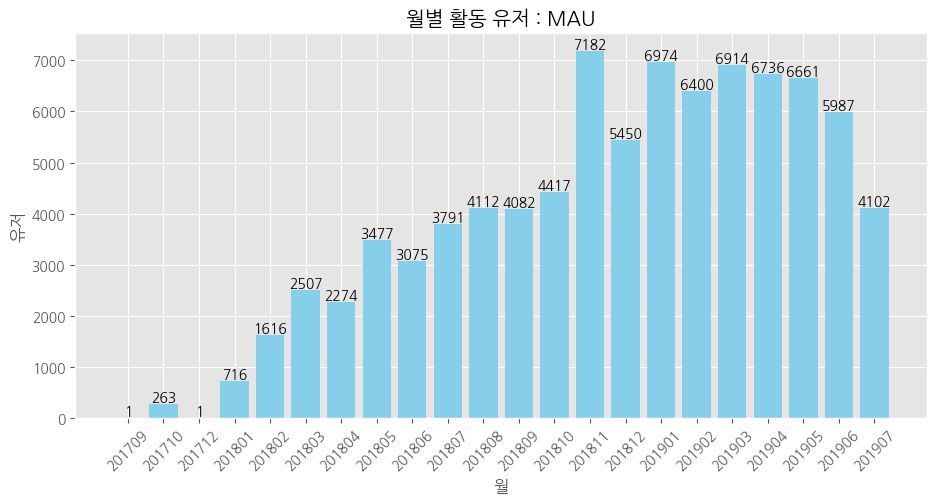

In [11]:
# 바 차트 그리기
plt.figure(figsize=(11, 5))
bars = plt.bar(orders_monthly_active['YearMonth'], orders_monthly_active['Customer_unique_id'], color='skyblue')

# 타이틀 및 라벨 설정
plt.title('월별 활동 유저 : MAU')
plt.xlabel('월')
plt.ylabel('유저')
plt.xticks(rotation=45)

# 각 바 위에 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.show()

C:\Users\SeonB2\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


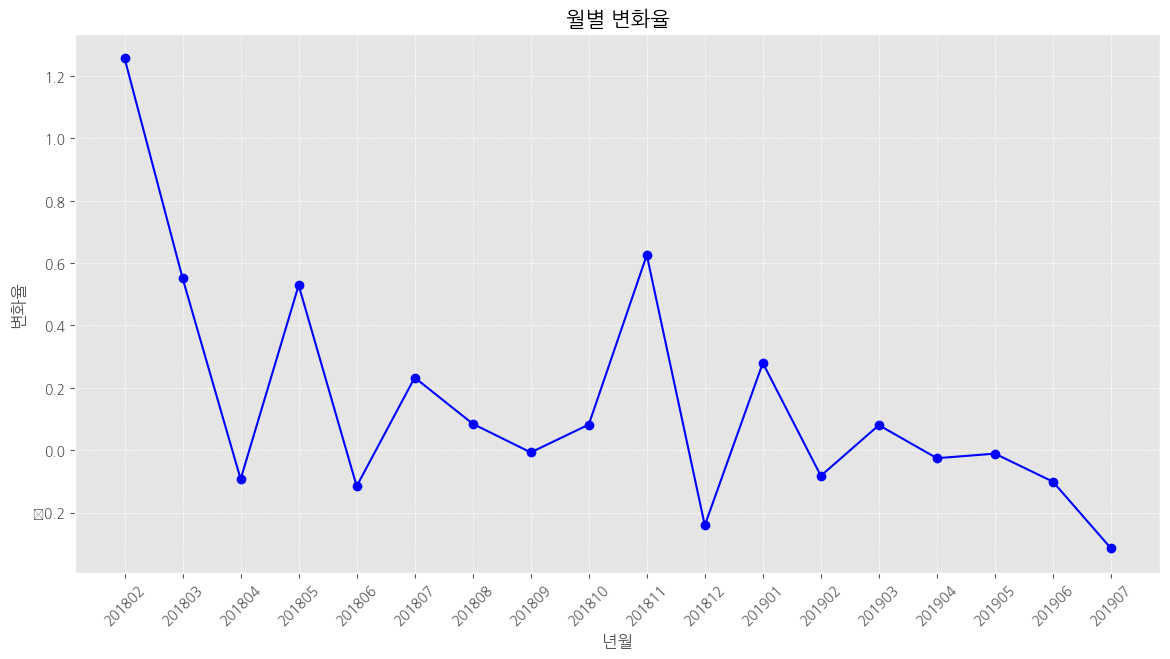

In [12]:
orders_monthly_active['Monthlychange'] = orders_monthly_active['Customer_unique_id'].pct_change()


filtered_data = orders_monthly_active.query("YearMonth > '201801'")


plt.figure(figsize=(14, 7))
plt.plot(filtered_data['YearMonth'], filtered_data['Monthlychange'], marker='o', linestyle='-', color='blue')
plt.title('월별 변화율', fontsize=15)
plt.xlabel('년월', fontsize=12)
plt.ylabel('변화율', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

In [13]:
customer

,Customer_id,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state
0,CUSTOMER_00000,CUSTOMER_Unique_00000,14409,franca,SP
1,CUSTOMER_00001,CUSTOMER_Unique_00001,9790,sao bernardo do campo,SP
2,CUSTOMER_00002,CUSTOMER_Unique_00002,1151,sao paulo,SP
3,CUSTOMER_00003,CUSTOMER_Unique_00003,8775,mogi das cruzes,SP
4,CUSTOMER_00004,CUSTOMER_Unique_00004,89254,jaragua do sul,SC
...,...,...,...,...,...
87950,CUSTOMER_88083,CUSTOMER_Unique_85234,3937,sao paulo,SP
87951,CUSTOMER_88084,CUSTOMER_Unique_85235,6764,taboao da serra,SP
87952,CUSTOMER_88085,CUSTOMER_Unique_85236,60115,fortaleza,CE
87953,CUSTOMER_88086,CUSTOMER_Unique_85237,92120,canoas,RS


In [14]:
order_items

,Order_id,Order_item_id,Product_id,Seller_id,Price,Freight_value
0,ORDER_75477,1,PRODUCT_23128,SELLER_0452,58.90,13.29
1,ORDER_63604,1,PRODUCT_24351,SELLER_0414,239.90,19.93
2,ORDER_05566,1,PRODUCT_20226,SELLER_1637,199.00,17.87
3,ORDER_04632,1,PRODUCT_07878,SELLER_1445,199.90,18.14
4,ORDER_61452,1,PRODUCT_03505,SELLER_0581,21.90,12.69
...,...,...,...,...,...,...
100552,ORDER_70405,1,PRODUCT_04209,SELLER_2078,299.99,43.41
100553,ORDER_62069,1,PRODUCT_08229,SELLER_1593,350.00,36.53
100554,ORDER_46632,1,PRODUCT_21462,SELLER_0528,99.90,16.95
100555,ORDER_52966,1,PRODUCT_19978,SELLER_2563,55.99,8.72


In [15]:
orders

,Order_id,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date
0,ORDER_00000,CUSTOMER_62232,delivered,2018-10-02 10:56:33,2018-10-04 19:55:00,2018-10-10 21:25:13,2018-10-18
1,ORDER_00001,CUSTOMER_54059,delivered,2018-11-18 19:28:06,2018-11-22 13:39:59,2018-12-02 00:28:42,2018-12-15
2,ORDER_00002,CUSTOMER_59535,delivered,2019-02-13 21:18:39,2019-02-14 19:46:34,2019-02-16 18:17:02,2019-02-26
3,ORDER_00003,CUSTOMER_60516,delivered,2018-07-09 21:57:05,2018-07-11 14:58:04,2018-07-26 10:57:55,2018-08-01
4,ORDER_00004,CUSTOMER_76957,delivered,2018-05-16 13:10:30,2018-05-22 10:07:46,2018-05-26 12:55:51,2018-06-07
...,...,...,...,...,...,...,...
87950,ORDER_88083,CUSTOMER_53611,delivered,2018-03-09 09:54:05,2018-03-10 11:18:03,2018-03-17 15:08:01,2018-03-28
87951,ORDER_88084,CUSTOMER_69438,delivered,2019-02-06 12:58:58,2019-02-07 23:22:42,2019-02-28 17:37:56,2019-03-02
87952,ORDER_88085,CUSTOMER_17637,delivered,2018-08-27 14:46:43,2018-08-28 20:52:26,2018-09-21 11:24:17,2018-09-27
87953,ORDER_88086,CUSTOMER_15001,delivered,2019-01-08 21:28:27,2019-01-12 15:35:03,2019-01-25 23:32:54,2019-02-15


In [16]:
payments

,Order_id,Payment_sequential,Payment_type,Payment_installments,Payment_value
0,ORDER_66617,1,credit_card,8,99.33
1,ORDER_86954,1,credit_card,1,24.39
2,ORDER_38852,1,credit_card,1,65.71
3,ORDER_57443,1,credit_card,8,107.78
4,ORDER_11244,1,credit_card,2,128.45
...,...,...,...,...,...
91966,ORDER_46197,1,credit_card,1,194.11
91967,ORDER_37509,1,credit_card,2,198.94
91968,ORDER_85760,1,boleto,1,363.31
91969,ORDER_35237,1,credit_card,2,96.80


In [17]:
product

,Product_id,Product_category_name,Product_weight_g,Product_length_cm,Product_height_cm,Product_width_cm
0,PRODUCT_00000,perfumery,225.0,16.0,10.0,14.0
1,PRODUCT_00001,arts,1000.0,30.0,18.0,20.0
2,PRODUCT_00002,sports_leisure,154.0,18.0,9.0,15.0
3,PRODUCT_00003,home_utilities,625.0,20.0,17.0,13.0
4,PRODUCT_00004,musical_instruments,200.0,38.0,5.0,11.0
...,...,...,...,...,...,...
29466,PRODUCT_29466,furniture_decor,12300.0,40.0,40.0,40.0
29467,PRODUCT_29467,construction_tools_lighting,1700.0,16.0,19.0,16.0
29468,PRODUCT_29468,bed_bath_table,1400.0,27.0,7.0,27.0
29469,PRODUCT_29469,computers_accessories,700.0,31.0,13.0,20.0


In [18]:
review

,Review_id,Order_id,Review_score,Review_creation_date,Review_answer_timestamp
0,REVIEW_00000,ORDER_01674,4,2019-01-18 00:00:00,2019-01-18 21:46:59
1,REVIEW_00001,ORDER_80140,5,2019-03-10 00:00:00,2019-03-11 03:05:13
2,REVIEW_00002,ORDER_69816,5,2019-02-17 00:00:00,2019-02-18 14:36:24
3,REVIEW_00003,ORDER_24398,5,2018-04-21 00:00:00,2018-04-21 22:02:06
4,REVIEW_00004,ORDER_70366,5,2019-03-01 00:00:00,2019-03-02 10:26:53
...,...,...,...,...,...
87868,REVIEW_87298,ORDER_58840,5,2019-07-07 00:00:00,2019-07-14 17:18:30
87869,REVIEW_87299,ORDER_75162,5,2018-12-09 00:00:00,2018-12-11 20:06:42
87870,REVIEW_87300,ORDER_08690,5,2019-03-22 00:00:00,2019-03-23 09:10:43
87871,REVIEW_87301,ORDER_25681,4,2019-07-01 00:00:00,2019-07-02 12:59:13


In [19]:
seller

,Seller_id,Seller_zipcode_prefix,Seller_city,Seller_state
0,SELLER_0000,13023,campinas,SP
1,SELLER_0001,13844,mogi guacu,SP
2,SELLER_0002,12914,braganca paulista,SP
3,SELLER_0003,20920,rio de janeiro,RJ
4,SELLER_0004,55325,brejao,PE
...,...,...,...,...
2758,SELLER_2758,87111,sarandi,PR
2759,SELLER_2759,88137,palhoca,SC
2760,SELLER_2760,4650,sao paulo,SP
2761,SELLER_2761,96080,pelotas,RS


In [20]:
total = pd.merge(customer, orders, how= 'left', on= 'Customer_id')

In [21]:
total

,Customer_id,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Order_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date
0,CUSTOMER_00000,CUSTOMER_Unique_00000,14409,franca,SP,ORDER_78362,delivered,2018-05-16 15:05:35,2018-05-23 10:47:57,2018-05-25 10:35:35,2018-06-05
1,CUSTOMER_00001,CUSTOMER_Unique_00001,9790,sao bernardo do campo,SP,ORDER_80079,delivered,2019-01-12 20:48:24,2019-01-15 17:14:59,2019-01-29 12:41:19,2019-02-06
2,CUSTOMER_00002,CUSTOMER_Unique_00002,1151,sao paulo,SP,ORDER_19946,delivered,2019-05-19 16:07:45,2019-06-11 14:31:00,2019-06-14 17:58:51,2019-06-13
3,CUSTOMER_00003,CUSTOMER_Unique_00003,8775,mogi das cruzes,SP,ORDER_28477,delivered,2019-03-13 16:06:38,2019-03-27 23:22:42,2019-03-28 16:04:25,2019-04-10
4,CUSTOMER_00004,CUSTOMER_Unique_00004,89254,jaragua do sul,SC,ORDER_61678,delivered,2018-09-14 18:14:31,2018-09-18 21:27:40,2018-09-28 17:32:43,2018-10-04
...,...,...,...,...,...,...,...,...,...,...,...
87950,CUSTOMER_88083,CUSTOMER_Unique_85234,3937,sao paulo,SP,ORDER_01632,delivered,2019-04-07 15:48:17,2019-04-11 02:08:36,2019-04-13 20:06:37,2019-04-25
87951,CUSTOMER_88084,CUSTOMER_Unique_85235,6764,taboao da serra,SP,ORDER_14304,delivered,2019-04-04 08:20:22,2019-04-05 18:42:35,2019-04-11 18:54:45,2019-04-20
87952,CUSTOMER_88085,CUSTOMER_Unique_85236,60115,fortaleza,CE,ORDER_62627,delivered,2019-04-08 20:11:50,2019-04-09 17:52:17,2019-05-09 19:03:15,2019-05-02
87953,CUSTOMER_88086,CUSTOMER_Unique_85237,92120,canoas,RS,ORDER_27295,delivered,2018-11-03 21:08:33,2018-11-06 18:24:41,2018-11-16 19:58:39,2018-12-05


In [22]:
total = pd.merge(total, order_items, how= 'left', on= 'Order_id')

In [23]:
total = pd.merge(total, payments, how= 'left', on= 'Order_id')

In [24]:
total = pd.merge(total, product, how= 'left', on= 'Product_id')

In [25]:
total = pd.merge(total, review, how= 'left', on= 'Order_id')

In [26]:
total

,Customer_id,Customer_unique_id,Customer_zipcode_prefix,Customer_city,Customer_state,Order_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,...,Payment_value,Product_category_name,Product_weight_g,Product_length_cm,Product_height_cm,Product_width_cm,Review_id,Review_score,Review_creation_date,Review_answer_timestamp
0,CUSTOMER_00000,CUSTOMER_Unique_00000,14409,franca,SP,ORDER_78362,delivered,2018-05-16 15:05:35,2018-05-23 10:47:57,2018-05-25 10:35:35,...,146.87,office_furniture,8683.0,54.0,64.0,31.0,REVIEW_21510,4.0,2018-05-26 00:00:00,2018-05-30 22:34:40
1,CUSTOMER_00001,CUSTOMER_Unique_00001,9790,sao bernardo do campo,SP,ORDER_80079,delivered,2019-01-12 20:48:24,2019-01-15 17:14:59,2019-01-29 12:41:19,...,335.48,home_utilities,10150.0,89.0,15.0,40.0,REVIEW_59463,5.0,2019-01-30 00:00:00,2019-02-10 22:43:29
2,CUSTOMER_00002,CUSTOMER_Unique_00002,1151,sao paulo,SP,ORDER_19946,delivered,2019-05-19 16:07:45,2019-06-11 14:31:00,2019-06-14 17:58:51,...,157.73,office_furniture,8267.0,52.0,52.0,17.0,REVIEW_38655,5.0,2019-06-15 00:00:00,2019-06-15 12:10:59
3,CUSTOMER_00003,CUSTOMER_Unique_00003,8775,mogi das cruzes,SP,ORDER_28477,delivered,2019-03-13 16:06:38,2019-03-27 23:22:42,2019-03-28 16:04:25,...,173.30,office_furniture,12160.0,56.0,51.0,28.0,REVIEW_63173,5.0,2019-03-29 00:00:00,2019-04-02 18:36:47
4,CUSTOMER_00004,CUSTOMER_Unique_00004,89254,jaragua do sul,SC,ORDER_61678,delivered,2018-09-14 18:14:31,2018-09-18 21:27:40,2018-09-28 17:32:43,...,282.21,sports_leisure,4450.0,60.0,15.0,15.0,REVIEW_86796,5.0,2018-09-29 00:00:00,2018-10-01 21:52:53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105762,CUSTOMER_88083,CUSTOMER_Unique_85234,3937,sao paulo,SP,ORDER_01632,delivered,2019-04-07 15:48:17,2019-04-11 02:08:36,2019-04-13 20:06:37,...,88.78,books_general_interest,611.0,22.0,22.0,23.0,REVIEW_18446,4.0,2019-04-14 00:00:00,2019-04-28 11:15:04
105763,CUSTOMER_88084,CUSTOMER_Unique_85235,6764,taboao da serra,SP,ORDER_14304,delivered,2019-04-04 08:20:22,2019-04-05 18:42:35,2019-04-11 18:54:45,...,129.06,sports_leisure,1211.0,25.0,24.0,22.0,REVIEW_16968,5.0,2019-04-12 00:00:00,2019-04-16 10:36:05
105764,CUSTOMER_88085,CUSTOMER_Unique_85236,60115,fortaleza,CE,ORDER_62627,delivered,2019-04-08 20:11:50,2019-04-09 17:52:17,2019-05-09 19:03:15,...,56.04,health_beauty,870.0,25.0,20.0,18.0,REVIEW_84501,1.0,2019-05-04 00:00:00,2019-05-08 01:41:07
105765,CUSTOMER_88086,CUSTOMER_Unique_85237,92120,canoas,RS,ORDER_27295,delivered,2018-11-03 21:08:33,2018-11-06 18:24:41,2018-11-16 19:58:39,...,711.07,watches_gifts,710.0,19.0,13.0,14.0,REVIEW_16121,5.0,2018-11-17 00:00:00,2018-11-19 23:34:18


In [27]:
total = pd.merge(total, seller, how= 'left', on= 'Seller_id')

In [28]:
total['Revenue'] = total['Price'] * total['Order_item_id']

In [32]:
total['Revenue'].describe()

count    105766.000000
mean        135.722351
std         215.415849
min           0.850000
25%          44.990000
50%          83.900000
75%         149.840000
max       13440.000000
Name: Revenue, dtype: float64

In [33]:
total.to_csv('./total.csv')